© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/phd_students/seleznova/index.html) 2022

https://github.com/mselezniova/MSML22

Distributed under the [Creative Commons Attribution License](https://creativecommons.org/licenses/by/4.0/)

# Softmax regression on Letter Recognition Data Set

In [12]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

import matplotlib
import matplotlib.pyplot as plt

import os

import numpy as np
import pandas as pd

We first load the [Letter Recognition Data Set](https://archive.ics.uci.edu/ml/datasets/Letter+Recognition), which contains 16 numerical features derived from images of capital letters of the English alphabet. The task is to classify the inputs into 26 classes, each corresponding to one of the alphabet letters.

In [2]:
file_name = 'letter-recognition.data'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data'
column_names = ['letter','x-box','y-box','width','high','onpix','x-bar','y-bar','x2bar','y2bar','xybar',
               'x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx']
    
if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, index_col=0)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from local file `letter-recognition.data`...


In [3]:
df

,letter,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,D,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3,7
19996,C,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3,7
19997,T,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2,4
19998,S,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5,8


Split the data into train and test subsets:

In [4]:
def  train_test_split(df, training_data_fraction, shuffle=True):

    if shuffle is True:
        df_ = df.sample(frac=1).reset_index(drop=True)
    else:
        df_= df
    
    train_df = df_.iloc[:round(training_data_fraction*len(df_)),:]
    test_df = df_.iloc[round(training_data_fraction*len(df_)):,:]
    
    return df_, train_df, test_df

training_data_fraction = .8

df, train_df, test_df =  train_test_split(df, training_data_fraction)

X = df.iloc[: , 1:].to_numpy()
Y = df.iloc[: , 0].to_numpy()

train_X = train_df.iloc[: , 1:].to_numpy()
train_Y = train_df.iloc[ : , 0].to_numpy()

test_X = test_df.iloc[: , 1:].to_numpy()
test_Y = test_df.iloc[: , 0].to_numpy()

print('Training data split as follows:')
print(f'  Training data samples: {len(train_df)}')
print(f'      Test data samples: {len(test_df)}')

Training data split as follows:
  Training data samples: 16000
      Test data samples: 4000


We implement three models for multiclass classification: **linear (least squares) classification**, **OvR logistic regression** and **softmax regression**:

In [5]:
class LinearMulticlassClassification:

    def __init__(self, w, b):
        
        self._params = np.vstack((np.array(w, dtype=float),  # stack the parameters into a single matrix [W,B]                                
                                  np.array(b, dtype=float))) # of shape (d+1,K)
        
        self._w = self._params[:-1,:] # save views of the parameters array as _w and _b
        self._b = self._params[-1,:]  # it's not a copy! when _params changes, _w and _b change
                                      # and vise versa
         
        self.labels = None            # class labels (can be different from [0,1,2])
                                      # labels are saved when the classifier sees Y during training
        
        self.history = [{'w': self._w.copy(),
                         'b': self._b.copy(),
                         'loss': None,
                         'accuracy': None}]
        
        
        
    def h(self, X):
        # the code accounts for any shape of X of the form (n1,n2,...np,d)
        # where d - the number of features
        
        ones_vec = np.ones(X.shape[:-1]+(1,)) # array of ones with shape (n1,n2,...np,1),
        
        _X = np.concatenate((X,ones_vec), axis=-1) # adds new dimension with value one to each point in X
                                                   # (x1,x2,...xd) is transformed to (x1,x2,...xd,1)
                                                   # the shape of X changes from (n1,n2,...np,d) 
                                                   # to (n1,n2,...np,d+1)  
        
        return np.argmax(_X@self._params, axis=-1)
    
    def accuracy(self, X, Y):
        return 1. - np.mean(self.labels[self.h(X)] != Y)
    
    def _accuracy(self, X, Y):
        return 1. - np.mean(np.argmax(X@self._params, axis=-1) != np.argmax(Y, axis=-1))
    
    def _loss(self, X, Y):
        lin_term = X@self._params - Y
        return 0.5/X.shape[0]*np.linalg.norm(lin_term)
    
    def _loss_grad(self, X,Y):
        
        lin_term = X@self._params - Y
        grad = X.T@lin_term/X.shape[0]
        return grad[:-1,:], grad[-1,:]
    
    def _labels_encoding(self, Y):
        # one-hot-encoding of the outputs
        # into vectors of 1s (corresponding to the correct class) and -1s
        self.labels = np.unique(Y)
        K = self.labels.size
        y_t = -np.ones(Y.shape+(K,))
    
        for k in range(K):
            ind = np.argwhere(Y==self.labels[k]).T.tolist()
            ind.append([k]*len(ind[0]))
            y_t[tuple(ind)] = 1

        return y_t

    def train(self, X, Y, lr = 1e-3, num_iter = 100, verbose=False):
        
        ones_vec = np.ones(X.shape[:-1]+(1,))
        _X = np.concatenate((X,ones_vec), axis=-1) # same shape transformation as in h()
        _X = _X.reshape((-1,_X.shape[-1]))         # make X two dimensional
                                                   # of shape (n1*n2*...*np,d+1)
        _Y = self._labels_encoding(Y) 
            
        self.history[0]['loss'] = self._loss(_X,_Y)
        self.history[0]['accuracy'] = self._accuracy(_X,_Y)
        
        for e in range(num_iter):
            
            grad_w, grad_b = self._loss_grad(_X,_Y)
            self._w -= lr*grad_w
            self._b -= lr*grad_b
            
            loss = self._loss(_X,_Y)
            acc = self._accuracy(_X,_Y)
           
            self.history.append({'w': self._w.copy(),
                                 'b': self._b.copy(),
                                 'loss': loss,
                                 'accuracy': acc})
            
            if verbose==True:
                if e%100==0:
                    print(f'Epoch {e}/{num_iter}. Loss value: {loss}, accuracy: {acc}')     
            
        return self._w, self._b

class MulticlassLogisticRegression(LinearMulticlassClassification):

    def __init__(self, w, b):
        
        super().__init__(w,b)
        self.activation = lambda x: 1./(1.+np.exp(-x))
        
        
        
    def h(self, X):
        # the code accounts for any shape of X of the form (n1,n2,...np,d)
        # where d - the number of features
        
        ones_vec = np.ones(X.shape[:-1]+(1,)) # array of ones with shape (n1,n2,...np,1),
        
        _X = np.concatenate((X,ones_vec), axis=-1) # adds new dimension with value one to each point in X
                                                   # (x1,x2,...xd) is transformed to (x1,x2,...xd,1)
                                                   # the shape of X changes from (n1,n2,...np,d) 
                                                   # to (n1,n2,...np,d+1)  
        
        return np.argmax(self.activation(_X@self._params), axis=-1)
    
    def _accuracy(self, X, Y):
        pred = self.activation(X@self._params)
        return 1. - np.mean(np.argmax(pred, axis=-1) != np.argmax(Y, axis=-1))
    
    def _loss(self, X, Y):
        lin_term = self.activation(X@self._params)
        return -np.mean(Y*np.log(lin_term) + (1.-Y)*(np.log(1.-lin_term)))
    
    def _loss_grad(self, X,Y):
        
        lin_term = self.activation(X@self._params) - Y
        grad = X.T@lin_term/X.shape[0]
        return grad[:-1,:], grad[-1,:]
    
    def _labels_encoding(self, Y):
        # one-hot-encoding of the outputs
        # into vectors of 0s and 1s
        self.labels = np.unique(Y)
        K = self.labels.size
        y_t = np.zeros(Y.shape+(K,))
    
        for k in range(K):
            ind = np.argwhere(Y==self.labels[k]).T.tolist()
            ind.append([k]*len(ind[0]))
            y_t[tuple(ind)] = 1

        return y_t
    
class SoftmaxRegression(LinearMulticlassClassification):
    
    def __init__(self, w, b):
        super().__init__(w,b)
        self.activation = lambda x: np.exp(x)/np.sum(np.exp(x),axis=-1, keepdims=True)
    
    def h(self,x):
        return self.activation(x @ self._w + self._b)
   
    def accuracy(self,X,Y):
        pred = self.labels[np.argmax(self.h(X), axis=-1)]
        return 1. - np.sum( pred != Y)/Y.size
    
    def _accuracy(self, X, Y):
        pred = np.argmax(self.activation(X@self._params), axis=-1)
        return 1. - np.mean( pred != np.argmax(Y, axis=-1))
    
    def _loss(self, X, Y):
        lin_term = self.activation(X@self._params)
        return -np.mean(Y*np.log(lin_term))
    
    def _loss_grad(self, X,Y):
        
        lin_term = self.activation(X@self._params) - Y
        grad = X.T@lin_term/X.shape[0]
        
        return grad[:-1,:], grad[-1,:]
    
    def _labels_encoding(self, Y):
        # one-hot-encoding of the outputs
        # into vectors of 0s and 1s
        self.labels = np.unique(Y)
        K = self.labels.size
        y_t = np.zeros(Y.shape+(K,))
    
        for k in range(K):
            ind = np.argwhere(Y==self.labels[k]).T.tolist()
            ind.append([k]*len(ind[0]))
            y_t[tuple(ind)] = 1
            
        return y_t
    
    

Train a softmax regression model:

In [6]:
w = np.zeros((X.shape[1],np.unique(Y).size))
b = [0]*np.unique(Y).size

model = SoftmaxRegression(w,b)
model.train(train_X, train_Y, lr = 5e-2, num_iter = 10000, verbose=True)

Epoch 0/10000. Loss value: 0.12336154471725273, accuracy: 0.20756249999999998
Epoch 100/10000. Loss value: 0.06582499549331723, accuracy: 0.6313124999999999
Epoch 200/10000. Loss value: 0.05503841851248598, accuracy: 0.6750625
Epoch 300/10000. Loss value: 0.04999296622064228, accuracy: 0.697125
Epoch 400/10000. Loss value: 0.0469505670707008, accuracy: 0.7105
Epoch 500/10000. Loss value: 0.044877609972259154, accuracy: 0.71925
Epoch 600/10000. Loss value: 0.04335928018512426, accuracy: 0.726125
Epoch 700/10000. Loss value: 0.042192406683503526, accuracy: 0.7315625
Epoch 800/10000. Loss value: 0.0412641610929587, accuracy: 0.73725
Epoch 900/10000. Loss value: 0.04050623620000325, accuracy: 0.7401875
Epoch 1000/10000. Loss value: 0.0398745939285548, accuracy: 0.74325
Epoch 1100/10000. Loss value: 0.03933944608302505, accuracy: 0.7461249999999999
Epoch 1200/10000. Loss value: 0.03887986105857839, accuracy: 0.7483124999999999
Epoch 1300/10000. Loss value: 0.03848066550563521, accuracy: 0.7

(array([[-7.48858691e-01, -1.38398458e-01,  5.37576449e-01,
         -1.88520728e-01, -2.62001157e-01, -4.11179765e-01,
          2.16940949e-01, -1.22876191e-01, -1.36806926e-01,
         -5.07047557e-02, -1.71420910e-01, -4.22718944e-01,
          3.20720682e-01, -2.86022010e-01,  1.81492583e-01,
          5.40823491e-02,  7.41467652e-01, -2.86441668e-01,
         -3.18469894e-01,  5.87180163e-01,  4.91940097e-01,
          2.42501551e-01,  3.35554885e-01, -4.05961001e-01,
          4.92352140e-01, -2.51428400e-01],
        [ 1.66897541e-01,  8.49845777e-02,  1.37196757e-01,
          1.91639767e-01,  6.74922196e-02,  3.28681970e-02,
          9.47879222e-02, -1.13398551e-01,  2.27413572e-01,
         -2.96618674e-01, -9.49749032e-03,  4.26768643e-01,
         -3.45444956e-02,  8.71521625e-03,  4.00021455e-03,
         -2.99515008e-01, -3.43024292e-01,  9.66096008e-02,
          3.15868104e-02,  1.93409785e-01,  1.55185164e-01,
          7.38688017e-02, -2.20999016e-01,  3.34878756e-

The final train accuracy: 77.0%
Test accuracy: 75.8%


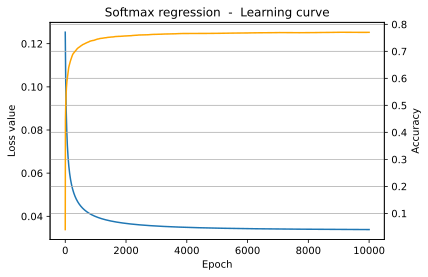

In [7]:
fig, ax = plt.subplots()

loss_history = [h['loss'] for h in model.history]
acc_history = [h['accuracy'] for h in model.history]

ax.plot(range(len(model.history)), loss_history)
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(model.history)), acc_history, color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Softmax regression  -  Learning curve')
plt.grid()

print(f'The final train accuracy: {round(100*acc_history[-1],1)}%')
print(f'Test accuracy: {round(100*model.accuracy(test_X, test_Y),1)}%')

The final accuracy of **75%** is still far from perfect. However, it is also much better than random classification for a problem with 26 classes. 

For comparison, we also train a logistic regression model and a least squares classification model:

In [8]:
w = np.zeros((X.shape[1],np.unique(Y).size))
b = [0]*np.unique(Y).size

model = MulticlassLogisticRegression(w,b)
model.train(train_X, train_Y, lr = 5e-2, num_iter = 10000, verbose=True)

Epoch 0/10000. Loss value: 0.5415445503935089, accuracy: 0.20756249999999998
Epoch 100/10000. Loss value: 0.10694768526747794, accuracy: 0.6254375
Epoch 200/10000. Loss value: 0.09777271095297559, accuracy: 0.6543125000000001
Epoch 300/10000. Loss value: 0.09366145921568449, accuracy: 0.6699999999999999
Epoch 400/10000. Loss value: 0.0912645249939663, accuracy: 0.6779375000000001
Epoch 500/10000. Loss value: 0.08968056828532839, accuracy: 0.683
Epoch 600/10000. Loss value: 0.0885527770868915, accuracy: 0.6865625
Epoch 700/10000. Loss value: 0.08770827137611807, accuracy: 0.69025
Epoch 800/10000. Loss value: 0.0870522228901457, accuracy: 0.6936249999999999
Epoch 900/10000. Loss value: 0.08652806569713307, accuracy: 0.6965625
Epoch 1000/10000. Loss value: 0.08609990768754838, accuracy: 0.698625
Epoch 1100/10000. Loss value: 0.08574384948139167, accuracy: 0.6990624999999999
Epoch 1200/10000. Loss value: 0.08544334508618341, accuracy: 0.7001875
Epoch 1300/10000. Loss value: 0.0851865649540

(array([[-8.15062357e-01,  5.77812324e-02,  3.82700093e-01,
         -1.73368012e-02, -2.71147819e-02, -4.89697564e-01,
          1.73009610e-01, -1.19984813e-02, -3.78266745e-03,
          7.68292968e-02, -1.69545859e-01, -2.50950685e-01,
         -4.29848963e-02, -5.09285123e-01,  3.16163470e-01,
          2.00029051e-02,  6.13671804e-01, -1.21528485e-01,
         -1.81317309e-02,  4.96116681e-01,  5.83097461e-01,
          1.14265722e-01, -6.25160523e-02, -4.89732747e-01,
          3.54818292e-01, -1.30376156e-01],
        [ 1.66542421e-01,  5.36088350e-02,  8.66134927e-02,
          1.95559770e-01,  6.60291649e-02,  5.90561085e-02,
          7.81330983e-02, -8.60480611e-04,  3.38304343e-01,
         -4.21339073e-01, -1.90557628e-02,  4.31681342e-01,
         -2.96504763e-02,  1.28675982e-01,  6.22443819e-02,
         -1.80618071e-01, -3.35840112e-01,  1.30879681e-01,
          1.71967921e-01,  1.72517843e-01,  1.87681287e-01,
          2.83316096e-01, -1.12081551e-02,  9.39217751e-

The final train accuracy: 71.0%
Test accuracy: 70.7%


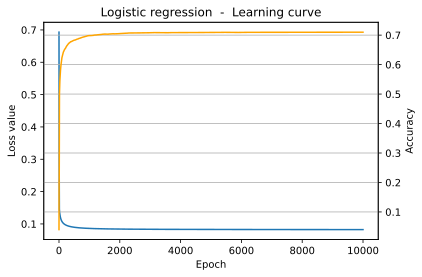

In [9]:
fig, ax = plt.subplots()

loss_history = [h['loss'] for h in model.history]
acc_history = [h['accuracy'] for h in model.history]

ax.plot(range(len(model.history)), loss_history)
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(model.history)), acc_history, color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Logistic regression  -  Learning curve')
plt.grid()

print(f'The final train accuracy: {round(100*acc_history[-1],1)}%')
print(f'Test accuracy: {round(100*model.accuracy(test_X, test_Y),1)}%')

In [10]:
w = np.zeros((X.shape[1],np.unique(Y).size))
b = [0]*np.unique(Y).size

model = LinearMulticlassClassification(w,b)
model.train(train_X, train_Y, lr = 1e-4, num_iter = 20000, verbose=True)

Epoch 0/20000. Loss value: 0.019109038494130377, accuracy: 0.20756249999999998
Epoch 100/20000. Loss value: 0.007984991075402983, accuracy: 0.43025
Epoch 200/20000. Loss value: 0.007890292047174665, accuracy: 0.45475
Epoch 300/20000. Loss value: 0.007814014142286075, accuracy: 0.465125
Epoch 400/20000. Loss value: 0.00775173847272834, accuracy: 0.47324999999999995
Epoch 500/20000. Loss value: 0.007700234399034143, accuracy: 0.479125
Epoch 600/20000. Loss value: 0.0076571025638906415, accuracy: 0.484
Epoch 700/20000. Loss value: 0.007620549739318858, accuracy: 0.48924999999999996
Epoch 800/20000. Loss value: 0.007589225391346693, accuracy: 0.49168750000000006
Epoch 900/20000. Loss value: 0.007562103507416215, accuracy: 0.4945625
Epoch 1000/20000. Loss value: 0.0075383972382186215, accuracy: 0.4965625
Epoch 1100/20000. Loss value: 0.007517497162746759, accuracy: 0.49887499999999996
Epoch 1200/20000. Loss value: 0.007498926498094894, accuracy: 0.5010625
Epoch 1300/20000. Loss value: 0.007

Epoch 11100/20000. Loss value: 0.007226636586618991, accuracy: 0.5450625
Epoch 11200/20000. Loss value: 0.007226272103596911, accuracy: 0.5454375
Epoch 11300/20000. Loss value: 0.007225914776945599, accuracy: 0.5454375
Epoch 11400/20000. Loss value: 0.007225564405178471, accuracy: 0.5453749999999999
Epoch 11500/20000. Loss value: 0.007225220793655396, accuracy: 0.5454375
Epoch 11600/20000. Loss value: 0.007224883754309593, accuracy: 0.545625
Epoch 11700/20000. Loss value: 0.007224553105387138, accuracy: 0.54575
Epoch 11800/20000. Loss value: 0.0072242286711984875, accuracy: 0.545875
Epoch 11900/20000. Loss value: 0.007223910281881353, accuracy: 0.545875
Epoch 12000/20000. Loss value: 0.007223597773174339, accuracy: 0.5459375
Epoch 12100/20000. Loss value: 0.00722329098620076, accuracy: 0.546
Epoch 12200/20000. Loss value: 0.007222989767262164, accuracy: 0.5461875
Epoch 12300/20000. Loss value: 0.007222693967640985, accuracy: 0.5463125
Epoch 12400/20000. Loss value: 0.007222403443411971

(array([[-1.33870316e-02,  1.82963130e-03,  1.67075070e-02,
         -4.13493992e-03, -2.53212339e-03, -1.29154891e-02,
          1.67130655e-02,  9.49616490e-03, -1.32779054e-02,
          1.72990379e-04,  3.69129315e-03,  3.78962299e-03,
         -1.22167581e-03,  1.87007342e-03,  1.42775954e-02,
         -1.67367842e-03,  3.47555768e-02,  7.14390542e-03,
          9.78991361e-03,  2.69010432e-02,  2.65274670e-02,
          1.68670140e-02,  9.80083554e-03, -5.34984923e-03,
          2.55730883e-02, -5.45518009e-04],
        [ 1.41379548e-03,  6.02744931e-03,  1.82282330e-03,
          4.50837391e-03,  3.37582466e-03,  2.70688376e-05,
          4.01628863e-03, -4.05660015e-03,  1.92313906e-02,
         -1.74364390e-02, -2.56437702e-03,  7.74357752e-03,
         -9.55264834e-03,  1.40110118e-03,  5.58001047e-03,
         -5.42167090e-03, -3.44076557e-02,  4.67948507e-03,
          9.15249006e-03,  7.74247041e-03,  1.56199979e-03,
          1.10627508e-02, -5.56263895e-03,  1.72932518e-

The final train accuracy: 55.2%
Test accuracy: 54.6%


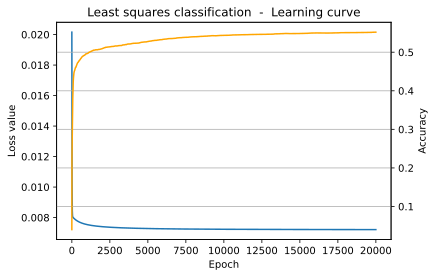

In [11]:
fig, ax = plt.subplots()

loss_history = [h['loss'] for h in model.history]
acc_history = [h['accuracy'] for h in model.history]

ax.plot(range(len(model.history)), loss_history)
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(model.history)), acc_history, color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Least squares classification  -  Learning curve')
plt.grid()

print(f'The final train accuracy: {round(100*acc_history[-1],1)}%')
print(f'Test accuracy: {round(100*model.accuracy(test_X, test_Y),1)}%')

We can see that the softmax regression model outperforms the other two!